# Feature Selection – Embedded Methods

Till now, I explored **Filter** and **Wrapper** methods for feature selection.  
They worked well, but:

- Filter methods are too simple – they ignore interactions between features.
- Wrapper methods are too slow – they train multiple models for different feature subsets.

**Embedded methods solve both problems** by doing feature selection **as part of model training**.  
This makes them **efficient** and allows them to consider **feature interactions**.

In this notebook, I want to go **deep** and really understand:

- What each embedded method does under the hood
- When to use which method
- How to implement them step by step with code
- How performance changes when I actually drop features


## Types of Embedded Methods

**Lasso Regression (L1)** → Performs automatic feature selection by shrinking some coefficients to zero ·  
**Ridge Regression (L2)** → Shrinks coefficients to reduce multicollinearity but keeps all features ·  
**Elastic Net (L1 + L2)** → Combines Lasso and Ridge to handle correlated features while performing selection ·  
**Tree-based Feature Importance (Random Forest / Decision Trees)** → Uses model-inherent feature importance to select relevant features without assuming linearity


## Baseline Model – Breast Cancer Dataset

Before diving into embedded methods, I want to set up a **baseline model** using all features.  
This will help me **compare performance later** when we drop features using Lasso, Ridge, Elastic Net, or Tree-based methods.

We are using **Breast Cancer dataset** from `sklearn` because it has a good number of features and is widely used for classification practice.


In [19]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split ,cross_val_score ,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score ,f1_score , classification_report

In [11]:
# Load dataset
df = load_breast_cancer()
X = pd.DataFrame(df.data , columns = df.feature_names)
y = pd.Series(df.target)

In [12]:
# Quick exploration
print("Shape of dataset:", X.shape)
X.head()

Shape of dataset: (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [14]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# Feature scaling (important for regularization-based models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# Baseline Logistic Regression (all features)
baseline_model = LogisticRegression(max_iter=10000, random_state=42)

In [21]:
# Stratified 5-Fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
# Accuracy
acc_scores = cross_val_score(baseline_model, X_train_scaled, y_train, cv=skf, scoring='accuracy')


In [23]:
# F1-score (macro average)
f1_scores = cross_val_score(baseline_model, X_train_scaled, y_train, cv=skf, scoring='f1_macro')

print(f"Baseline CV Accuracy (5-fold): {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
print(f"Baseline CV F1-score (5-fold): {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")


Baseline CV Accuracy (5-fold): 0.9780 ± 0.0098
Baseline CV F1-score (5-fold): 0.9764 ± 0.0106


### Observations from Baseline Model

- Accuracy and F1-score give us a **reference point** before any feature selection.  
- We are using all 30 features of the dataset.  
- Now, we can start applying **embedded methods** to see:
  - Which features are important
  - Whether dropping irrelevant features affects performance


## 1️. Lasso Regression (L1 Regularization)

**What is Lasso?**  
Lasso (Least Absolute Shrinkage and Selection Operator) is a linear regression model that uses **L1 regularization**.  
It **automatically performs feature selection** by shrinking some coefficients exactly to zero while keeping others.  
This is useful when I want a **sparse model**, i.e., a model using only the most important features.

---

**Mathematical Formulation**

The cost function of Lasso is:

$$
J(\beta) = \frac{1}{2n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 + \lambda \sum_{j=1}^{p} |\beta_j|
$$

Where:  
- $y_i$ = true target  
- $\hat{y}_i$ = predicted target  
- $n$ = number of samples  
- $p$ = number of features  
- $\beta_j$ = coefficient for feature $j$  
- $\lambda$ = regularization parameter controlling **shrinkage**

**Explanation of the Formula:**

1. First term: **Mean Squared Error (MSE)** → measures model fit  
2. Second term: **L1 penalty** → adds absolute value of coefficients  
   - Large $\lambda$ → more coefficients shrink to 0 → more feature selection  
   - Small $\lambda$ → behaves like regular linear regression  

**Intuition:**  
- Lasso pushes **irrelevant features** to zero because the L1 penalty grows linearly with coefficient size.  
- This is different from Ridge (L2), which **shrinks but rarely zeroes** coefficients.  
- Visual analogy: Lasso “clips” unimportant coefficients while leaving important ones relatively untouched.


In [24]:
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

In [25]:
# Fit Lasso with cross-validation to select best alpha
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [26]:
# Coefficients
lasso_coefs = pd.Series(lasso.coef_, index=X.columns)

In [27]:
# Number of features selected (non-zero coefficients)
num_selected = sum(lasso_coefs != 0)
print(f"Optimal alpha (λ) chosen by CV: {lasso.alpha_:.4f}")
print(f"Number of features selected by Lasso: {num_selected}")
print("\nSelected Features:\n", lasso_coefs[lasso_coefs != 0])

Optimal alpha (λ) chosen by CV: 0.0009
Number of features selected by Lasso: 23

Selected Features:
 mean texture              -0.028249
mean smoothness           -0.017779
mean compactness           0.169038
mean concavity            -0.066122
mean concave points       -0.057553
mean symmetry             -0.010035
radius error              -0.127322
texture error             -0.001874
perimeter error            0.032705
area error                 0.043767
smoothness error          -0.051740
concavity error            0.114589
concave points error      -0.056599
symmetry error             0.003312
fractal dimension error    0.008608
worst radius              -0.522829
worst texture             -0.043417
worst area                 0.348743
worst smoothness          -0.004369
worst concavity           -0.116376
worst concave points      -0.075038
worst symmetry            -0.043301
worst fractal dimension   -0.057375
dtype: float64


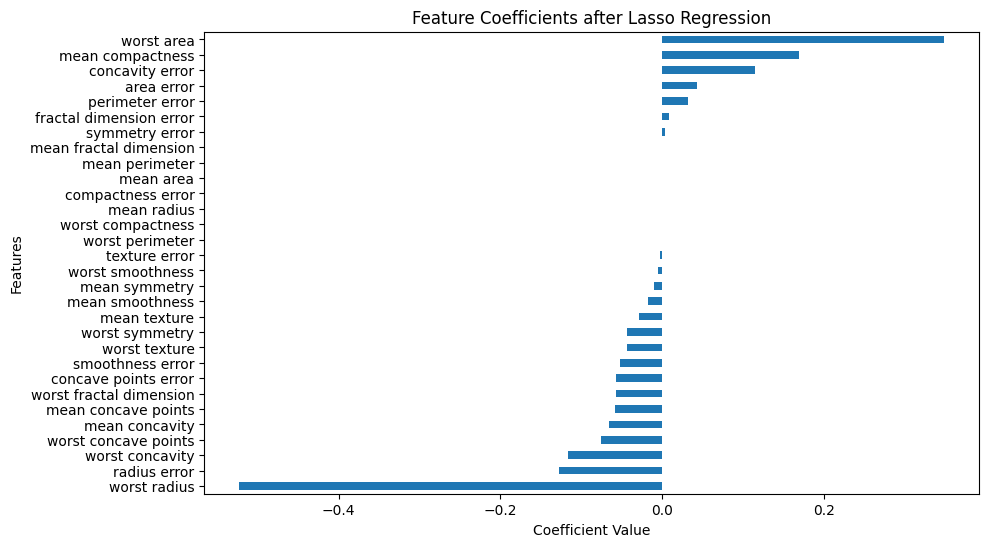

In [28]:
# Plot coefficient magnitudes
plt.figure(figsize=(10,6))
lasso_coefs.sort_values().plot(kind='barh')
plt.title("Feature Coefficients after Lasso Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.show()

**Retrain Model on Selected Features and Compare with Baseline**

In [29]:
# Used the same CV strategy as baseline
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Keep only features selected by Lasso
selected_features = lasso_coefs[lasso_coefs != 0].index
X_selected = X[selected_features]

# Logistic Regression model
lasso_model_cv = LogisticRegression(max_iter=10000, random_state=42)

# Evaluate with cross-validation (Accuracy)
acc_scores = cross_val_score(lasso_model_cv, X_selected, y, cv=cv, scoring='accuracy')
f1_scores = cross_val_score(lasso_model_cv, X_selected, y, cv=cv, scoring='f1')

print(f"Lasso Selected Features Accuracy (CV mean): {acc_scores.mean():.4f}")
print(f"Lasso Selected Features F1-score (CV mean): {f1_scores.mean():.4f}")


Lasso Selected Features Accuracy (CV mean): 0.9490
Lasso Selected Features F1-score (CV mean): 0.9599


### Inference from Lasso Feature Selection

- Using **Lasso regression**, we reduced the number of features by keeping only the most important ones.  
- **Baseline model (all 30 features)**:  
  - CV Accuracy: 0.9780 ± 0.0098  
  - CV F1-score: 0.9764 ± 0.0106  

- **Lasso-selected features (23 features)**:  
  - CV Accuracy: 0.9490  
  - CV F1-score: 0.9599  

**Key Takeaways:**

1. Lasso removed several irrelevant or less important features, simplifying the model.  
2. There is a **small drop in accuracy and F1-score**, but it is still very high → shows that the removed features were mostly redundant.  
3. This demonstrates the **power of embedded methods**:
   - Automatic feature selection
   - Reduced dimensionality
   - Easier interpretability  
4. For datasets with many irrelevant features, Lasso is a **great first step** to reduce noise before training more complex models.  

Overall, we achieved a **sparser model** with almost comparable performance, which is exactly what Lasso is designed to do.  



### Pros of Lasso

- Automatically selects **relevant features** → reduces dimensionality.  
- Produces a **sparse and interpretable model**.  
- Helps reduce **overfitting** by removing noisy features.  
- Cross-validation helps choose the optimal **λ** for best performance.

### Cons of Lasso

- Can be unstable if **features are highly correlated** → may randomly keep one and drop the others.  
- Might **drop too many features** if λ is too high → risk of underfitting.  
- Only works with models that support **L1 regularization** (mostly linear models).  


## 2️ .Ridge Regression (L2 Regularization)

**What is Ridge?**  
Ridge regression is a linear model that uses **L2 regularization**.  
Unlike Lasso, Ridge **does not zero out coefficients**, but it **shrinks them towards zero** to reduce multicollinearity and prevent overfitting.  

---

**Mathematical Formulation**

The cost function of Ridge is:

$$
J(\beta) = \frac{1}{2n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 + \lambda \sum_{j=1}^{p} \beta_j^2
$$

Where:  
- $y_i$ = true target  
- $\hat{y}_i$ = predicted target  
- $n$ = number of samples  
- $p$ = number of features  
- $\beta_j$ = coefficient for feature $j$  
- $\lambda$ = regularization parameter controlling shrinkage  

**Explanation:**
1. First term: **MSE** → measures model fit.  
2. Second term: **L2 penalty** → sum of squared coefficients.  
   - Large $\lambda$ → stronger shrinkage, coefficients become smaller  
   - Small $\lambda$ → behaves like ordinary linear regression  

**Intuition:**  
- Ridge reduces the impact of less important features **without removing them completely**.  
- Works well when features are **highly correlated** because it distributes weight among them.  

**When to Use:**  
- When multicollinearity exists among features  
- When we want **all features** to contribute but reduce overfitting  
- When a **stable and smooth model** is preferred over sparsity
